In [1]:
import time
import numpy as np
import pandas as pd

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').drop(['class_id'], axis=1)
df.head(10)

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,search_date_pacific
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,2018-01-21
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,2018-01-21
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,2018-01-21
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,2018-01-23
4,NaN,NaN,7.868900,0.008065,0.008772,0.0,7.0,0,2018-01-24
5,0.000000,0.198377,0.000000,0.022545,0.014706,1.0,16.0,0,2018-01-24
6,NaN,NaN,9.308552,0.005782,0.000003,NaN,0.0,0,2018-01-24
7,NaN,NaN,9.308552,0.005782,0.000003,NaN,0.0,0,2018-01-24
8,11.992127,0.118237,3.462835,0.017337,0.050844,0.0,23.0,0,2018-01-25
9,8.298727,0.000000,0.000000,0.019160,0.018750,1.0,0.0,0,2018-01-23


In [3]:
# columns_list = [['title_proximity_tfidf'], 
#                 ['description_proximity_tfidf', 'main_query_tfidf'], 
#                 ['query_jl_score', 'query_title_score'], 
#                 ['city_match', 'apply'], 
#                 ['job_age_days']]
# for columns in columns_list:
#     fig = go.Figure()
#     for column in columns:
#         fig.add_trace(go.Box(y=df[column], name=column))
#     fig.write_image(f"images/new distribution/distribution_before_outlier_clip/{' '.join(columns)}.png")

In [ ]:
df.drop_duplicates(inplace=True)

In [4]:
# outlier treatment except binary columns using clip
columns = ['title_proximity_tfidf', 'description_proximity_tfidf',
       'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days']
Q1 = df[columns].quantile(0.25)
Q3 = df[columns].quantile(0.75)
IQR = Q3 - Q1
# clip outliers
underfence = Q1 - 1.5 * IQR
upperfence = Q3 + 1.5 * IQR
df[columns] = df[columns].clip(underfence, upperfence, axis=1)

In [5]:
# columns = ['title_proximity_tfidf', 'description_proximity_tfidf',
#        'main_query_tfidf', 'query_jl_score', 'query_title_score', 'city_match',
#        'job_age_days', 'apply', 'search_date_pacific']
# fig = go.Figure()
# for column in columns:
#     fig.add_trace(go.Box(y=df[column], name=column))
# fig.write_image(f'images/new distribution/distribution_after_outlier_clip.png')

In [2]:
fig = go.Figure([go.Bar(x=df.columns, y=df.isnull().sum())])
fig.update_layout(xaxis_type='category', title_text='Number of null data', title_x=0.5)
fig.show()

In [6]:
fig = go.Figure([go.Bar(x=df['apply'].unique(), y=df['apply'].value_counts())])
fig.update_layout(xaxis_type='category', title_text='Apply frequency', title_x=0.5)
fig.show()  # imbalanced

In [7]:
# start preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# fill missing values by MICE, then change city_match back to 0/1
# because directly assign 0 to city_match will worsen the result.
df.iloc[:,:3] = IterativeImputer().fit_transform(df.iloc[:,:3])  # fillna probabilities
df.iloc[:,5:6] = IterativeImputer().fit_transform(df.iloc[:,5:6])  # fillna city_match, not relevant to others 
df['city_match'] = df['city_match'].round()

df.describe()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply
count,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06,1.086406e+06
mean,5.333413e+00,4.217564e-02,1.868819e+00,1.616906e-02,2.825162e-02,6.544027e-01,9.387922e+00,9.049379e-02
std,9.134088e+00,5.540485e-02,2.235507e+00,9.430582e-03,2.217813e-02,4.755628e-01,8.670843e+00,2.868880e-01
min,-3.487042e-01,0.000000e+00,0.000000e+00,1.000000e-06,9.998021e-07,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,1.043009e-02,1.229762e-02,0.000000e+00,2.000000e+00,0.000000e+00
50%,0.000000e+00,2.799273e-02,7.844908e-01,1.562717e-02,2.041954e-02,1.000000e+00,6.000000e+00,0.000000e+00
75%,1.035578e+01,4.863840e-02,3.570944e+00,2.069120e-02,3.824712e-02,1.000000e+00,1.500000e+01,0.000000e+00
max,2.986674e+01,1.651409e-01,8.927359e+00,3.608287e-02,7.717138e-02,1.000000e+00,3.450000e+01,1.000000e+00


In [8]:
print('number of NaN in title_proximity_tfidf:',len(df[df['title_proximity_tfidf'].isnull()]))
print('number of NaN in description_proximity_tfidf:',len(df[df['description_proximity_tfidf'].isnull()]))
print('number of NaN in city_match:',len(df[df['city_match'].isnull()]))

number of NaN in title_proximity_tfidf: 0
number of NaN in description_proximity_tfidf: 0
number of NaN in city_match: 0


In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# train_x, test_x = train_test_split(df, test_size=0.2, random_state=4211)
test_x = df[df['search_date_pacific']=='2018-01-27'].drop(['search_date_pacific'], axis=1)
train_x = df[df['search_date_pacific']!='2018-01-27'].drop(['search_date_pacific'], axis=1)
train_y = train_x.pop('apply')
test_y = test_x.pop('apply')

# Normalisation using the sklearn StandardScaler. Set the mean to 0 and sd to 1.
transform_columns = ['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days']
ct = ColumnTransformer(
        remainder='passthrough',
        transformers=[('std', StandardScaler(), transform_columns)])
train_x = ct.fit_transform(train_x)
test_x = ct.fit_transform(test_x)

# after ColumnTransformm, city_match is at the END of the dataframe
x_columns = ['title_proximity_tfidf', 'description_proximity_tfidf', 'main_query_tfidf', 'query_jl_score', 'query_title_score', 'job_age_days', 'city_match']
train_x = pd.DataFrame(train_x, columns=x_columns)
test_x = pd.DataFrame(test_x, columns=x_columns)

# over/under-sampling to reduce imbalance
train_x1, train_y1 = SMOTE(random_state=0).fit_resample(train_x, train_y)
train_x2, train_y2 = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)

print('After oversampling(SMOTE):')
train_x1.describe()

Using TensorFlow backend.
After oversampling(SMOTE):


,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,city_match
count,1.783492e+06,1.783492e+06,1.783492e+06,1.783492e+06,1.783492e+06,1.783492e+06,1.783492e+06
mean,5.979978e-02,-1.117391e-02,4.415396e-02,6.615951e-02,9.862896e-02,-3.391730e-02,6.595000e-01
std,1.038106e+00,9.961356e-01,1.007780e+00,1.026412e+00,1.047657e+00,9.855446e-01,4.738253e-01
min,-6.222741e-01,-7.621476e-01,-8.351030e-01,-1.715142e+00,-1.269159e+00,-1.083321e+00,0.000000e+00
25%,-5.840630e-01,-7.621476e-01,-8.351030e-01,-5.709839e-01,-6.846300e-01,-8.534829e-01,0.000000e+00
50%,-5.840630e-01,-2.798159e-01,-3.774114e-01,-3.351895e-02,-2.805532e-01,-3.938066e-01,1.000000e+00
75%,7.349815e-01,1.082033e-01,8.475006e-01,5.698336e-01,6.501831e-01,5.255460e-01,1.000000e+00
max,2.688746e+00,2.215150e+00,3.154603e+00,2.128115e+00,2.225694e+00,2.881387e+00,1.000000e+00


In [10]:
print('After undersampling(RandomUnderSampler):')
train_x2.describe()

After undersampling(RandomUnderSampler):


,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,job_age_days,city_match
count,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000,177208.000000
mean,0.061763,-0.007261,0.046599,0.068417,0.099261,-0.032193,0.659908
std,1.040419,0.997564,1.010452,1.027622,1.048637,0.985595,0.473741
min,-0.622274,-0.762148,-0.835103,-1.715142,-1.269159,-1.083321,0.000000
25%,-0.584063,-0.762148,-0.835103,-0.572176,-0.687114,-0.853483,0.000000
50%,-0.584063,-0.277178,-0.376455,-0.033519,-0.276665,-0.393807,1.000000
75%,0.736489,0.116081,0.850196,0.578055,0.656331,0.525546,1.000000
max,2.688746,2.215150,3.154603,2.128115,2.225694,2.881387,1.000000


In [11]:
print('After oversampling(SMOTE):')
fig = go.Figure([go.Bar(x=train_y1.unique(), y=train_y1.value_counts())])
fig.update_layout(xaxis_type='category', title_text='Apply frequency in over-sampling training set', title_x=0.5)
fig.show()

After oversampling(SMOTE):


In [12]:
print('After undersampling(RandomUnderSampler):')
fig = go.Figure([go.Bar(x=train_y2.unique(), y=train_y2.value_counts())])
fig.update_layout(xaxis_type='category', title_text='Apply frequency in under-sampling training set', title_x=0.5)
fig.show()

After undersampling(RandomUnderSampler):


In [13]:
def report(clf):
    pred_y = clf.predict(test_x)

    print(classification_report(test_y, pred_y))
    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")

def train(clf,x,y):
    start = time.time()
    clf_result = clf.fit(x, y)
    print(time.time()-start)
    report(clf)
    return clf_result

After oversampling(SMOTE):
2433.128272294998
              precision    recall  f1-score   support

           0       0.93      0.58      0.72     96347
           1       0.12      0.55      0.19      9709

    accuracy                           0.58    106056
   macro avg       0.52      0.57      0.45    106056
weighted avg       0.85      0.58      0.67    106056

After undersampling(RandomUnderSampler):
33.18222403526306
              precision    recall  f1-score   support

           0       0.93      0.62      0.74     96347
           1       0.12      0.53      0.20      9709

    accuracy                           0.61    106056
   macro avg       0.53      0.57      0.47    106056
weighted avg       0.85      0.61      0.69    106056



MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(80, 60), learning_rate='adaptive',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=4211, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

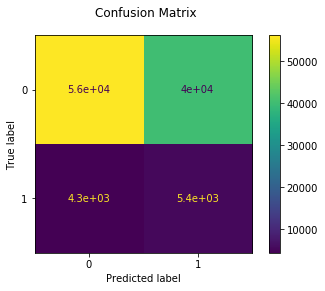

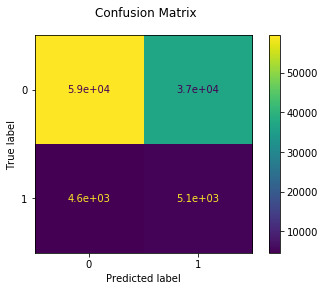

In [55]:
mlp1 = MLPClassifier(hidden_layer_sizes=(80, 60, ), learning_rate='adaptive', early_stopping=True, random_state=4211)
mlp2 = MLPClassifier(hidden_layer_sizes=(80, 60, ), learning_rate='adaptive', early_stopping=True, random_state=4211)
print('After oversampling(SMOTE):')
train(mlp1,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(mlp2,train_x2,train_y2)

In [ ]:
tuned_parameters = {
    'hidden_layer_sizes': [(120,), (80, 60,), (60, 40, 20,)]
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005],
    'momentum', [0.9, 0.8]
    'early_stopping': [True],
    'random_state': [4211]
}

clf = GridSearchCV(MLPClassifier(), tuned_parameters, n_jobs=-1, verbose=2)
train(clf,train_x1,train_y1)  # result saved in image folder

In [ ]:
tuned_parameters = {
    'hidden_layer_sizes': [(50, ), (100, ), (150, )],
    'activation':['relu','logistic','tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'learning_rate': ['invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.002, 0.005],
    'momentum': [0.9, 0.8],
    'early_stopping': [True],
    'random_state': [4211]
}

clf = GridSearchCV(MLPClassifier(), tuned_parameters, n_jobs=-1, verbose=2)
train(clf,train_x1,train_y1)  # result saved in image folder

After oversampling(SMOTE):
510.88720703125
              precision    recall  f1-score   support

           0       0.95      0.03      0.05     96347
           1       0.09      0.99      0.17      9709

    accuracy                           0.11    106056
   macro avg       0.52      0.51      0.11    106056
weighted avg       0.87      0.11      0.06    106056

After undersampling(RandomUnderSampler):
31.178612232208252
              precision    recall  f1-score   support

           0       0.93      0.63      0.75     96347
           1       0.12      0.52      0.20      9709

    accuracy                           0.62    106056
   macro avg       0.52      0.57      0.47    106056
weighted avg       0.85      0.62      0.70    106056



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=4211, tol=0.0001,
          verbose=0)

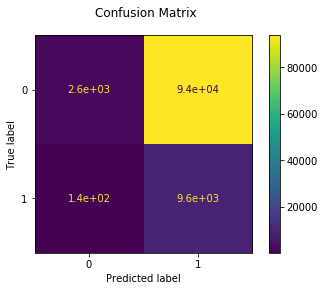

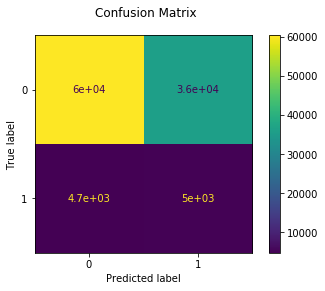

In [56]:
clf1 = LinearSVC(random_state=4211)
clf2 = LinearSVC(random_state=4211)
print('After oversampling(SMOTE):')
train(clf1,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(clf2,train_x2,train_y2)

After oversampling(SMOTE):
337.74638867378235
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     96347
           1       0.14      0.34      0.20      9709

    accuracy                           0.75    106056
   macro avg       0.53      0.56      0.52    106056
weighted avg       0.85      0.75      0.79    106056

After undersampling(RandomUnderSampler):
10.310414791107178
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     96347
           1       0.14      0.35      0.20      9709

    accuracy                           0.74    106056
   macro avg       0.53      0.56      0.52    106056
weighted avg       0.85      0.74      0.79    106056



LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='crammer_singer', penalty='l2', random_state=4211,
          tol=0.0001, verbose=0)

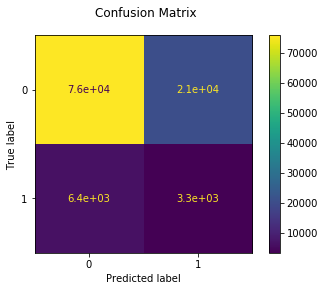

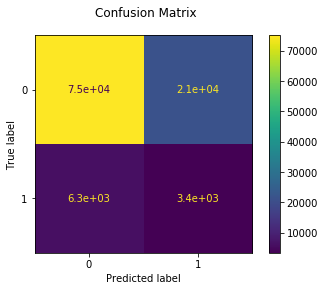

In [57]:
clf1 = LinearSVC(multi_class='crammer_singer', random_state=4211)
clf2 = LinearSVC(multi_class='crammer_singer', random_state=4211)
print('After oversampling(SMOTE):')
train(clf1,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(clf2,train_x2,train_y2)

After oversampling(SMOTE):
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 31.5min finished


1975.6690509319305
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     96347
           1       0.14      0.35      0.20      9709

    accuracy                           0.74    106056
   macro avg       0.53      0.56      0.52    106056
weighted avg       0.85      0.74      0.78    106056

After undersampling(RandomUnderSampler):
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.3min finished


143.03033304214478
              precision    recall  f1-score   support

           0       0.92      0.78      0.84     96347
           1       0.14      0.35      0.20      9709

    accuracy                           0.74    106056
   macro avg       0.53      0.56      0.52    106056
weighted avg       0.85      0.74      0.79    106056



GridSearchCV(cv=None, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'multi_class': ['crammer_singer'],
                         'random_state': [4211]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=2)

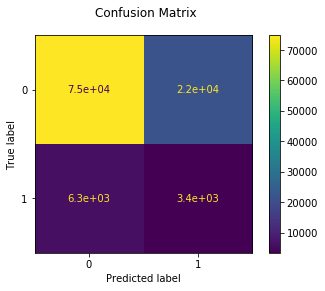

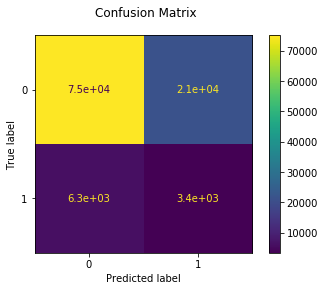

In [67]:
tuned_parameters = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                    'multi_class': ['crammer_singer'],
                    'random_state': [4211]
                    }

clf1 = GridSearchCV(LinearSVC(), tuned_parameters, n_jobs=-1, verbose=2)
clf2 = GridSearchCV(LinearSVC(), tuned_parameters, n_jobs=-1, verbose=2)
print('After oversampling(SMOTE):')
train(clf1,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(clf2,train_x2,train_y2)

In [68]:
clf1.best_estimator_

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='crammer_singer', penalty='l2', random_state=4211,
          tol=0.0001, verbose=0)

In [69]:
clf2.best_estimator_

LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='crammer_singer', penalty='l2', random_state=4211,
          tol=0.0001, verbose=0)

After oversampling(SMOTE):
385.6416664123535
              precision    recall  f1-score   support

           0       0.92      0.72      0.81     96347
           1       0.13      0.41      0.20      9709

    accuracy                           0.69    106056
   macro avg       0.53      0.57      0.50    106056
weighted avg       0.85      0.69      0.75    106056

After undersampling(RandomUnderSampler):
22.6623694896698
              precision    recall  f1-score   support

           0       0.93      0.67      0.78     96347
           1       0.12      0.46      0.20      9709

    accuracy                           0.65    106056
   macro avg       0.52      0.57      0.49    106056
weighted avg       0.85      0.65      0.73    106056



RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=2, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=4211,
                       verbose=0, warm_start=False)

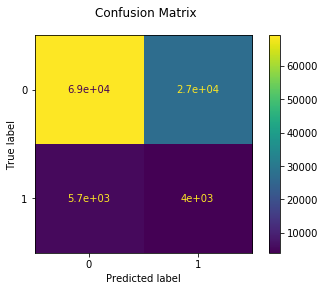

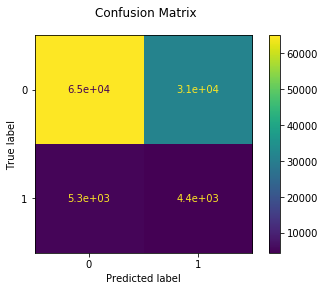

In [59]:
clf3 = RandomForestClassifier(n_estimators=100, max_depth=2, criterion='entropy', random_state=4211
                             ,max_features=None)
clf4 = RandomForestClassifier(n_estimators=100, max_depth=2, criterion='entropy', random_state=4211
                             ,max_features=None)
print('After oversampling(SMOTE):')
train(clf3,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(clf4,train_x2,train_y2)

After oversampling(SMOTE):
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 47.5min finished


3063.8030195236206
              precision    recall  f1-score   support

           0       0.96      0.00      0.01     96347
           1       0.09      1.00      0.17      9709

    accuracy                           0.10    106056
   macro avg       0.52      0.50      0.09    106056
weighted avg       0.88      0.10      0.02    106056

After undersampling(RandomUnderSampler):
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  3.7min finished


241.50089526176453
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     96347
           1       0.12      0.56      0.20      9709

    accuracy                           0.58    106056
   macro avg       0.52      0.57      0.45    106056
weighted avg       0.86      0.58      0.67    106056



GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
      

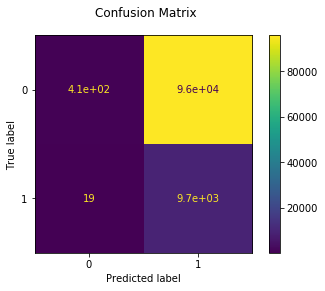

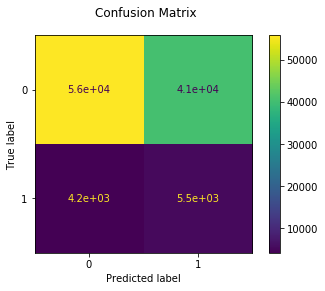

In [62]:
param_grid = {'scale_pos_weight': [1, 2, 5, 10]}
model = XGBClassifier()
grid1 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2)
grid2 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2)
print('After oversampling(SMOTE):')
train(grid1,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(grid2,train_x2,train_y2)

In [63]:
grid1.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [64]:
grid2.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

After oversampling(SMOTE):
216.66134095191956
              precision    recall  f1-score   support

           0       0.96      0.00      0.01     96347
           1       0.09      1.00      0.17      9709

    accuracy                           0.10    106056
   macro avg       0.52      0.50      0.09    106056
weighted avg       0.88      0.10      0.02    106056

After undersampling(RandomUnderSampler):
16.064022302627563
              precision    recall  f1-score   support

           0       0.93      0.58      0.71     96347
           1       0.12      0.56      0.20      9709

    accuracy                           0.58    106056
   macro avg       0.52      0.57      0.45    106056
weighted avg       0.86      0.58      0.67    106056



XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

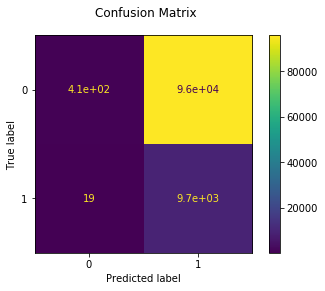

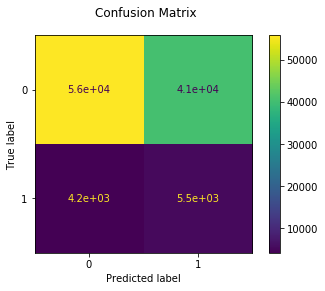

In [65]:
clf5 = XGBClassifier(scale_pos_weight=1, n_jobs=-1)
clf6 = XGBClassifier(scale_pos_weight=1, n_jobs=-1)
print('After oversampling(SMOTE):')
train(clf5,train_x1,train_y1)
print('After undersampling(RandomUnderSampler):')
train(clf6,train_x2,train_y2)